In [1]:
import numpy as np
import random
from sklearn.datasets import fetch_openml

# load MNIST training and test data
mnist = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
x, y = mnist.data, mnist.target
y = y.astype(int) 
x = (x - np.mean(x))/np.std(x)
N = 60000 # length of training data
x, x_test = x[0:N], x[N:len(y)]
y, y_test = y[0:N], y[N:len(y)]

# softmax function
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

# sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Jacobian matrix of the sigmoid
def J_sigmoid(z):
    return np.diag(1/(2 + np.exp(z) + np.exp(-z)))

# likelihood for classes 0,...,9 given x[j],theta
def likelihood(A,B,a,b,x):
    return softmax(A.T@sigmoid(B.T@x + b) + a)

d = len(x[0]) # get dimension of x
G = 10 # number of classes
basis = np.eye(G) # get standard unit vectors
dh = 100 # dimension of hidden layer
sigma2 = 0.001 # sigma^2 of prior density of q

# gradient of the log likelihood for datapoint j and given theta
def gradient(A,B,a,b,j):
    z = B.T@x[j] + b
    gradient_outer = basis[y[j]] - likelihood(A, B, a, b, x[j])
    gradient_inner = gradient_outer@A.T@J_sigmoid(z)
    return gradient_outer, np.outer(sigmoid(z), gradient_outer), gradient_inner, np.outer(x[j], gradient_inner)

# calculate accuracy of prediction 
def accuracy(A,B,a,b,testlen):
    y_predict = np.zeros(testlen)
    for j in range(len(y_predict)):
        likelihood_current = np.zeros(G)
        for n in range(len(A)):
            likelihood_current += likelihood(A[n],B[n],a[n],b[n],x_test[j])
        y_predict[j] = np.argmax(likelihood_current) # predict labels for test data
    return np.mean((y_predict==y_test[0:testlen]).astype(int)) # get accuracy

# calculate accuracy of prediction at every step of the algorithm
def accuracy_plot(A,B,a,b,testlen):
    accuracies = np.zeros(len(A))
    y_predict = np.zeros(testlen)
    likelihood_current = np.zeros((testlen, G))
    for n in range(len(A)):
        for j in range(len(y_predict)):
            likelihood_current[j] += likelihood(A[n],B[n],a[n],b[n],x_test[j])
            y_predict[j] = np.argmax(likelihood_current[j]) # predict labels for test data
        accuracies[n] = np.mean((y_predict==y_test[0:testlen]).astype(int)) # get accuracy
    return accuracies

In [2]:
# stochastic gradient ascent
A_mode = np.zeros((dh,G))
B_mode = np.random.randn(d,dh)
b_mode = np.zeros(dh)
a_mode = np.zeros(G)
eta = 0.000001 # learning rate
m = 100 # subsample size
for n in range(1000):
    Sm = np.random.choice(np.arange(0,N), size=m, replace=False) # get random sample 
    gradient_est_A = -1/sigma2*A_mode
    gradient_est_B = -1/sigma2*B_mode
    gradient_est_b = -1/sigma2*b_mode
    gradient_est_a = -1/sigma2*a_mode
    for j in Sm: # estimate gradient using subsample
        summand_a, summand_A, summand_b, summand_B = gradient(A_mode, B_mode, a_mode, b_mode, j)
        gradient_est_a += N/m*summand_a
        gradient_est_A += N/m*summand_A
        gradient_est_b += N/m*summand_b
        gradient_est_B += N/m*summand_B
    A_mode += eta*gradient_est_A # update theta_mode
    B_mode += eta*gradient_est_B
    b_mode += eta*gradient_est_b
    a_mode += eta*gradient_est_a

In [3]:
print("Accuarcy using theta_mode:", accuracy(np.array([A_mode]),np.array([B_mode]),np.array([a_mode]),np.array([b_mode]),len(y_test)))

Accuarcy using theta_mode: 0.8446


In [4]:
# SGLD
M = 1000 # steps of Markov Chain
A = np.zeros((M,dh,G))
B = np.zeros((M,d,dh))
b = np.zeros((M,dh))
a = np.zeros((M,G))
delta = 0.00001 # step size
m = 100 # subsample size
for n in range(M-1):
    Sm = np.random.choice(np.arange(0,N), size=m, replace=False) # get random sample 
    gradient_est_A = -1/sigma2*A[n]
    gradient_est_B = -1/sigma2*B[n]
    gradient_est_b = -1/sigma2*b[n]
    gradient_est_a = -1/sigma2*a[n]
    for j in Sm: # estimate gradient using subsample
        summand_a, summand_A, summand_b, summand_B = gradient(A[n], B[n], a[n], b[n], j)
        gradient_est_a += N/m*summand_a
        gradient_est_A += N/m*summand_A
        gradient_est_b += N/m*summand_b
        gradient_est_B += N/m*summand_B
    A[n+1] = A[n] + delta/2*gradient_est_A + np.random.normal(loc=0, scale=delta, size=(dh,G)) # update Markov Chain
    B[n+1] = B[n] + delta/2*gradient_est_B + np.random.normal(loc=0, scale=delta, size=(d,dh))
    b[n+1] = b[n] + delta/2*gradient_est_b + np.random.normal(loc=0, scale=delta, size=dh)
    a[n+1] = a[n] + delta/2*gradient_est_a + np.random.normal(loc=0, scale=delta, size=G)

In [5]:
print("Accuarcy using SGLD:", accuracy(A,B,a,b,100))

Accuarcy using SGLD: 0.91


In [6]:
# calculate control variates
sum_co_va_a = sum_co_va_b = sum_co_va_A = sum_co_va_B = 0
for j in range(N):
    control_vars_a,  control_vars_A, control_vars_b, control_vars_B = gradient(A_mode, B_mode, a_mode, b_mode, j)
    sum_co_va_a += control_vars_a
    sum_co_va_b += control_vars_b
    sum_co_va_A += control_vars_A
    sum_co_va_B += control_vars_B
# variance reduced SGLD
M = 1000 # steps of Markov Chain
A_vr = np.zeros((M,dh,G))
B_vr = np.zeros((M,d,dh))
b_vr = np.zeros((M,dh))
a_vr = np.zeros((M,G))
A_vr[0], B_vr[0], a_vr[0], b_vr[0] = A_mode, B_mode, a_mode, b_mode
delta = 0.00001 # step size
m = 100 # subsample size
for n in range(M-1):
    Sm = np.random.choice(np.arange(0,N), size=m, replace=False) # get random sample 
    gradient_est_A = -1/sigma2*A_vr[n] + sum_co_va_A
    gradient_est_B = -1/sigma2*B_vr[n] + sum_co_va_B
    gradient_est_b = -1/sigma2*b_vr[n] + sum_co_va_b
    gradient_est_a = -1/sigma2*a_vr[n] + sum_co_va_a
    for j in Sm: # estimate gradient using subsample
        summand_a, summand_A, summand_b, summand_B = gradient(A_vr[n], B_vr[n], a_vr[n], b_vr[n], j)
        control_vars_a,  control_vars_A, control_vars_b, control_vars_B = gradient(A_mode, B_mode, a_mode, b_mode, j)
        gradient_est_a += N/m*(summand_a - control_vars_a)
        gradient_est_A += N/m*(summand_A - control_vars_A)
        gradient_est_b += N/m*(summand_b - control_vars_b)
        gradient_est_B += N/m*(summand_B - control_vars_B)
    A_vr[n+1] = A_vr[n] + delta/2*gradient_est_A + np.random.normal(loc=0, scale=delta, size=(dh,G)) # update Markov Chain
    B_vr[n+1] = B_vr[n] + delta/2*gradient_est_B + np.random.normal(loc=0, scale=delta, size=(d,dh))
    b_vr[n+1] = b_vr[n] + delta/2*gradient_est_b + np.random.normal(loc=0, scale=delta, size=dh)
    a_vr[n+1] = a_vr[n] + delta/2*gradient_est_a + np.random.normal(loc=0, scale=delta, size=G)

In [7]:
print("Accuarcy using variance reduced SGLD:", accuracy(A_vr,B_vr,a_vr,b_vr,100)) 

Accuarcy using variance reduced SGLD: 0.92


In [8]:
accuracies = accuracy_plot(A,B,a,b,1000) # calculate accuracies of SGLD

In [9]:
accuracies_vr = accuracy_plot(A_vr,B_vr,a_vr,b_vr,1000) # calculate accuracies of VRSGLD

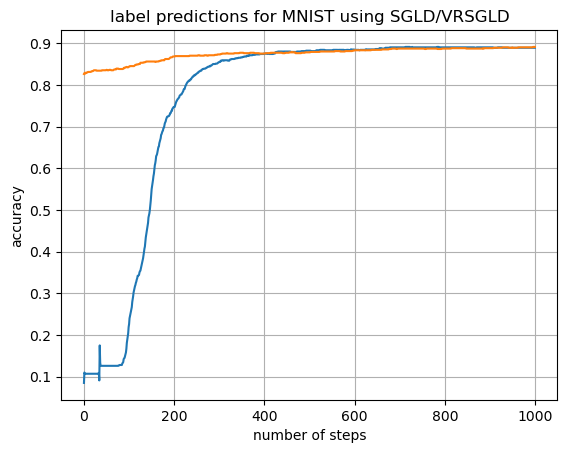

In [10]:
# create a plot of the accuracy of prediction for SGLD and VRSGLD
import matplotlib.pyplot as plt

plt.plot(np.arange(M), accuracies)
plt.plot(np.arange(M), accuracies_vr)
plt.title("label predictions for MNIST using SGLD/VRSGLD")
plt.xlabel("number of steps")
plt.ylabel("accuracy")
plt.grid(True)
plt.savefig("MNISTplot.pdf")
plt.show()